# Gaussian Mixture Model & Expectation - Maximization Algorithm




In [20]:
import pandas as pd
from ipysketch import Sketch

In [21]:
sk = Sketch('gmm')

In [23]:
sk

Button(description='Edit', style=ButtonStyle())

Output()

![gmm](../contents/gmm.PNG)

## Variables explanations

* $\pi_k$: probability of grabbing a sample from distribution $k$ (in this case Gaussian $k$)
* $N(\vec{x}_n | \mu_k, \Sigma_k)$: given Gaussian distribution parameters mean ($\mu_k$), and covariance ($\Sigma_k$), the probability of getting a sample result $\vec{x}_n$
* $\gamma_{nk}$: Given that we have got a sample $\vec{x}_n$, the probability that this sample comes from distribution $k$. (Note this is derived from Bayes rule: $\gamma_{nk} := p(z_k | \vec{x}_n) \propto p(\vec{x}_n | z_k)\cdot p(z_k) = N(\vec{x}_n | \mu_k, \Sigma_k) \cdot \pi_k$
* $T_n$: probability of grabbing a sample result $\vec{x}_n$ from the whole population
* $p(\vec{X})$: probability of achieving a consecutive results $(\vec{x}_1, \vec{x}_2, ..., \vec{x}_N)$ (since we assume each experiment is independent), this term is called **likelihood**
* $\ln p(\vec{X})$: the **log-likelihood**
* $N_k$: probability that the consecutive results $(\vec{x}_1, \vec{x}_2, ..., \vec{x}_N)$ come from distribution $k$
* $(\pi_k^*, \mu_k^*, \Sigma_k^*)$: updated parameters

## 3 steps of expectation-maximization algorithm (iterative method)

1. In *Initialization step*,  we must initialise our parameters $(\pi_k, \mu_k, \Sigma_k)$. In this case, we are going to use the results of KMeans as an initial value for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. We could also use random numbers for everything, but using a sensible initialisation procedure will help the algorithm achieve better results.

2. In *Expectation step*, we calculate the matrix elements $\gamma_{nk}$. This is the *expected values* from our guess of the parameters $(\pi_k, \mu_k, \Sigma_k)$.

3. In *Maximization step*, we update the parameters to $(\pi_k^*, \mu_k^*, \Sigma_k^*)$




## Ref

1. [知乎：【机器学习】EM——期望最大（非常详细）](https://zhuanlan.zhihu.com/p/78311644)
2. [GMM Implementation](https://github.com/ocontreras309/ML_Notebooks/blob/master/GMM_Implementation.ipynb)
3. [Gaussian Mixture Models Explained](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)

<h2 style="color:orange"> Synthetic Example </h2>

For this example let's assume we know the true means, sigmas, and prior probabilities for each of the distributions (here we assume there are two distributions: `risky` and `stable`), and we want to test the ability of the EM algorithm to recover this information from noisy data.

In [102]:
from typing import List, Dict
import pandas as pd
import numpy as np
import sklearn.mixture as mix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 2022

In [103]:
def create_fake_data(
        true_mus: Dict[str, float],
        true_sigmas: Dict[str, float],
        true_probs: Dict[str, float],
        n: int
) -> pd.Series:
    """create mixed dataset using binomial and random normal distributions

    Params
    ------
    true_mus: dict
        contains 'stable' and 'risky' regime means
    true_sigmas: dict
        contains 'stable' and 'risky' regime stds
    true_probs: dict
        contains 'stable' and 'risky' regime probabilities
    n: int
        number of samples

    Returns
    -------
    fake_returns: pd.Series
    """
    np.random.seed(RANDOM_SEED)

    # randomly sample from binomial to select distr.
    zs = np.random.binomial(1, true_probs["risky"], n)
    regime_map = {0: "stable", 1: "risky"}

    xs = []
    for z in zs:
        # sample from normal distr. and associated parameters according to z
        xs.append(np.random.normal(true_mus[regime_map[z]], true_sigmas[regime_map[z]]))

    # fake dates to make it look real
    fake_dates = pd.period_range(start="2002", periods=n, freq="M")
    fake_returns = pd.Series(xs, index=fake_dates)
    return zs, fake_returns


In [104]:
true_mus    = {'stable': 0.15, 'risky': -0.25}
true_sigmas = {'stable': 0.20, 'risky': 0.35}
true_probs  = {'stable': 0.65, 'risky': 0.35}

actuals, mixed_data = create_fake_data(true_mus, true_sigmas, true_probs, n=250)
actuals

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1])

In [105]:
mixed_data

2002-01    0.042982
2002-02    0.253572
2002-03    0.054855
2002-04   -0.072086
2002-05    0.187175
             ...   
2022-06   -0.148320
2022-07    0.168147
2022-08   -0.096118
2022-09    0.395190
2022-10    0.036515
Freq: M, Length: 250, dtype: float64

plot the mixed up data

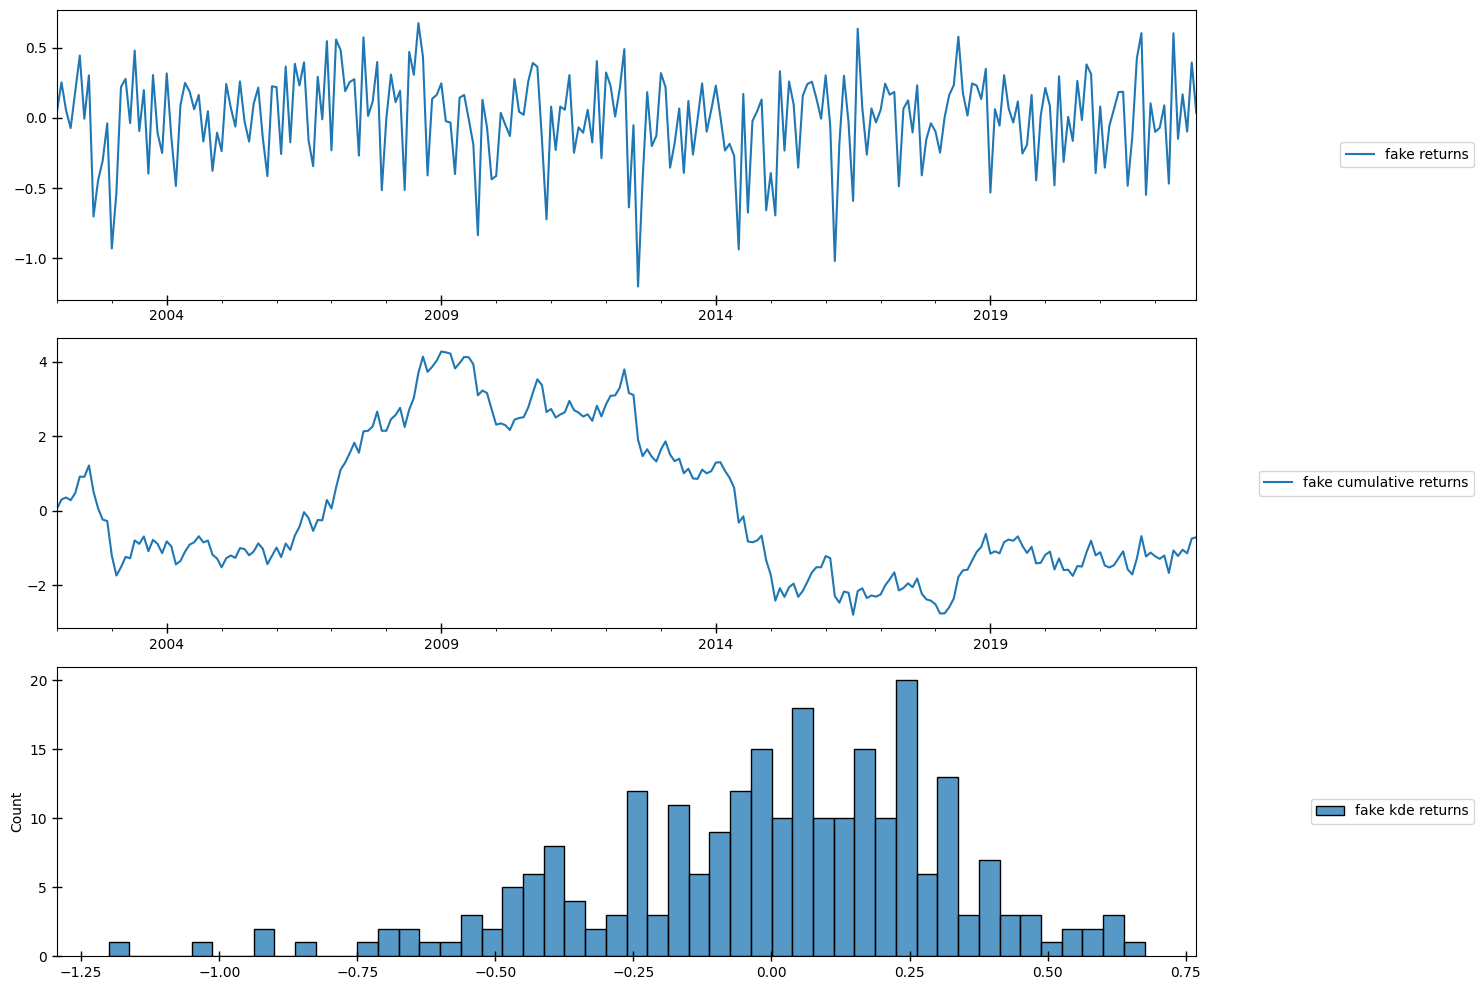

In [106]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 10))

mixed_data.plot(ax=axs[0], label="fake returns")
mixed_data.cumsum().plot(ax=axs[1], label="fake cumulative returns")
sns.histplot(mixed_data, ax=axs[2], kde_kws=dict(cut=0), bins=50, label="fake kde returns")
for ax in axs:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    ax.tick_params("both", direction="inout", length=7, width=1, which="major")
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()

In [107]:
gmm = mix.GaussianMixture(
    n_components=2,
    max_iter=1000,
    n_init=500,
    random_state=RANDOM_SEED
)

In [108]:
X = mixed_data.values.reshape(-1, 1)
X.shape

(250, 1)

In [109]:
gmm.fit(X)

GaussianMixture(max_iter=1000, n_components=2, n_init=500, random_state=2022)

In [110]:
preds = gmm.predict(X)

In [111]:
pd.DataFrame({"pred": preds, "actual": actuals})

,pred,actual
0,1,0
1,1,0
2,1,0
3,1,0
4,1,1
...,...,...
245,1,1
246,1,1
247,1,1
248,1,0


In [121]:
gmm_means = gmm.means_.ravel()
gmm_sigmas = np.sqrt(gmm.covariances_.ravel())
gmm_probs = [p_risky:=1-preds.sum() / len(preds), 1 - p_risky]

In [122]:
gmm_recovered_mus    = {'stable': gmm_means[1], 'risky': gmm_means[0]}
gmm_recovered_sigmas = {'stable': gmm_sigmas[1], 'risky': gmm_sigmas[0]}
gmm_recovered_probs = {'stable': gmm_probs[1], 'risky': gmm_probs[0]}

In [123]:
print("means: ")
print(f"\tTrue: {true_mus}, Recovered: {gmm_recovered_mus}")
print("sigmas: ")
print(f"\tTrue: {true_sigmas}, Recovered: {gmm_recovered_sigmas}")
print("probs: ")
print(f"\tTrue: {true_probs}, Recovered: {gmm_recovered_probs}")

means: 
	True: {'stable': 0.15, 'risky': -0.25}, Recovered: {'stable': 0.13189185631948244, 'risky': -0.3180933459176899}
sigmas: 
	True: {'stable': 0.2, 'risky': 0.35}, Recovered: {'stable': 0.21065048097856356, 'risky': 0.3026908530729577}
probs: 
	True: {'stable': 0.65, 'risky': 0.35}, Recovered: {'stable': 0.772, 'risky': 0.22799999999999998}


In [68]:
gmm.aic(X)

108.66895432210377

In [69]:
gmm.bic(X)

126.276258911415

In [117]:
preds.sum() / len(preds)

0.772